# **Vehicle Detection and Tracking** 

## 0. Required Imports Utils

In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
lif = './../lesson_images/'
cof = lif + 'cutouts/'
carfld = './../data/vehicles/'
nonfld = './../data/non-vehicles/'
out_img_folder = './output_images/'

In [3]:
cars = []
notcars = []
for folder in os.walk(carfld):
    folder_path = folder[0]
    for image in folder[2]:
        if '.DS_Store' in image:
            continue
        cars.append(folder_path + '/' + image)

for folder in os.walk(nonfld):
    folder_path = folder[0]
    for image in folder[2]:
        if '.DS_Store' in image:
            continue
        notcars.append(folder_path + '/' + image)

In [4]:
# Number samples by class in the data set
print(len(cars), len(notcars))

8792 8968


### Util Functions

In [5]:
# Function to convert image between color spaces
def convert_color(img, frm="BGR", to="RGB"):
    converted = None
    if (frm == to):
        converted = np.copy(img)
    elif (frm == "RGB" and to == "BGR") or (frm == "BGR" and to == "RGB"):
        r, g, b = cv2.split(img)
        converted = cv2.merge((b, g, r))
    elif (frm == "RGB"):
        if to == 'HSV':
            converted = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif to == 'LUV':
            converted = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif to == 'HLS':
            converted = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif to == 'YUV':
            converted = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif to == 'YCrCb':
            converted = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif (frm == "BGR"):
        if to == 'HSV':
            converted = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif to == 'LUV':
            converted = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif to == 'HLS':
            converted = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif to == 'YUV':
            converted = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif to == 'YCrCb':
            converted = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    return converted

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### Feature Extraction Functions

## 1. Histogram of Oriented Gradients (HOG)

In [7]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

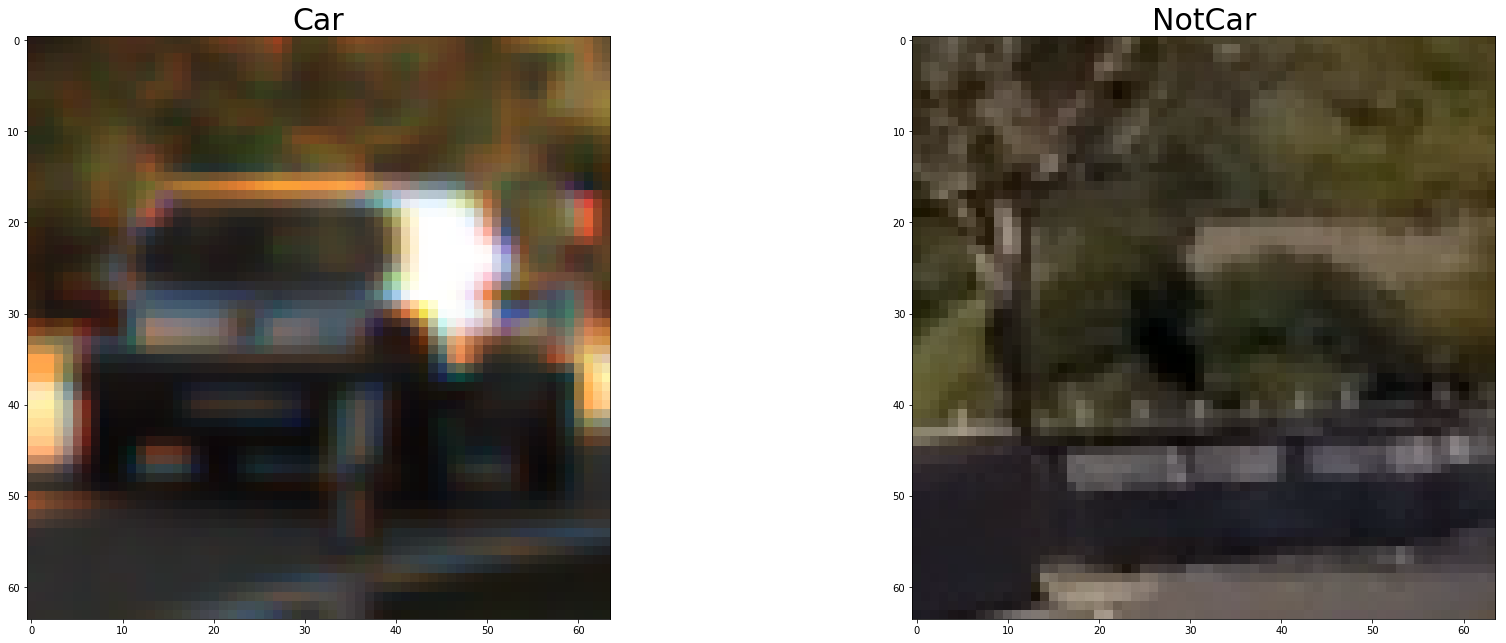

In [8]:
# Choose random
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=30)
ax2.imshow(notcar_image)
ax2.set_title('NotCar', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(out_img_folder + 'car_not_car.png')

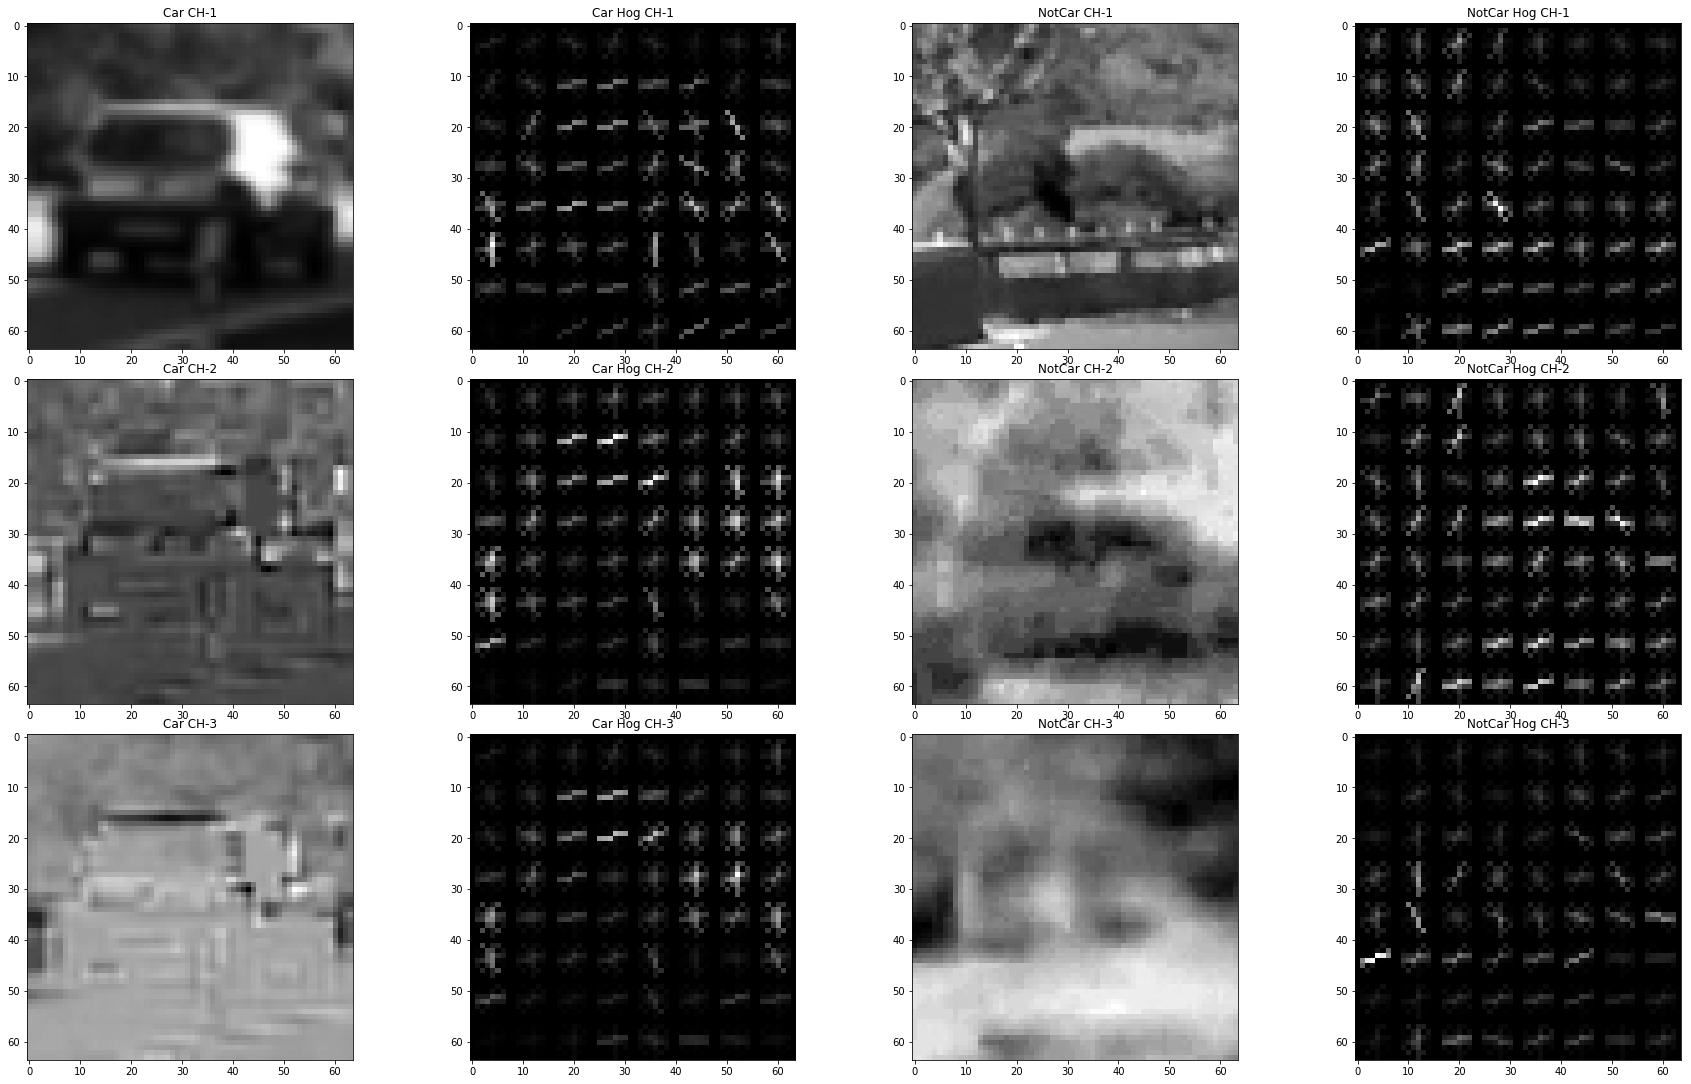

In [9]:
# Convert color space
car_image = convert_color(car_image, 'RGB', 'YCrCb')
notcar_image = convert_color(notcar_image, 'RGB', 'YCrCb')

# Define feature parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

n_channel = car_image.shape[2]

f, axs = plt.subplots(n_channel, 4, figsize=(24, 16))
f.tight_layout()


for hog_channel in range(3):
    car_channel = car_image[:,:,hog_channel]
    notcar_channel = notcar_image[:,:,hog_channel]
    car_features, car_hog_image = get_hog_features(car_channel, orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    notcar_features, notcar_hog_image = get_hog_features(notcar_channel, orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    axs[hog_channel,0].imshow(car_channel, cmap='gray')
    axs[hog_channel,0].set_title('Car CH-%d' %(hog_channel + 1))
    axs[hog_channel,1].imshow(car_hog_image, cmap='gray')
    axs[hog_channel,1].set_title('Car Hog CH-%d' %(hog_channel + 1))    
    axs[hog_channel,2].imshow(notcar_channel, cmap='gray')
    axs[hog_channel,2].set_title('NotCar CH-%d' %(hog_channel + 1))
    axs[hog_channel,3].imshow(notcar_hog_image, cmap='gray')
    axs[hog_channel,3].set_title('NotCar Hog CH-%d' %(hog_channel + 1))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(out_img_folder + 'HOG_example.jpg')    

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [11]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB',
                     orient=9,
                     pix_per_cell=8, cell_per_block=2,
                     hog_channel=0, spatial_size=(32, 32),
                     hist_bins=32, spatial_feat=True,
                     hist_feat=True, hog_feat=True, imreader='cv2'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        if imreader == 'cv2':
            image = cv2.imread(file)
            from_color = "BGR"
        else:
            image = mpimg.imread(file)
            from_color = "RGB"
        feature_image = convert_color(image, from_color, color_space)

        # Compute spatial features if flag is set
        if spatial_feat:
            spatial_features = bin_spatial(
                feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Compute histogram features if flag is set
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        # 7) Compute HOG features if flag is set
        if hog_feat:
            hog_features = []
            hog_channel_list = []
            if hog_channel == "ALL":
                hog_channel_list = [0, 1, 2]
            elif hog_channel in range(3):
                hog_channel_list.append(hog_channel)
            else:
                hog_channel_list = hog_channel
            for channel in range(feature_image.shape[2]):
                if channel in hog_channel_list:
                    hog_features.append(
                        get_hog_features(feature_image[:, :, channel],
                                         orient, pix_per_cell, cell_per_block,
                                         vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)

            # Append the new feature vector to the features list
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

In [13]:
class Classifier():
    def __init__(self, color_space="YCrCb", orient=9, pix_per_cell=8,
                 cell_per_block=2, hog_channel="ALL", spatial=16,
                 hist_bins=128, spatial_feat=True, hist_feat=True,
                 hog_feat=True, load_pre_svc=True):
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = (spatial, spatial)
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.load_pre_svc = load_pre_svc
        self.prm_str = "%s_%d_%d_%d_%s_%d_%d" % (color_space, orient,
                                                 pix_per_cell,
                                                 cell_per_block,
                                                 str(hog_channel),
                                                 spatial, hist_bins)
        self.prm_log = self.prm_str.replace('_', ',')
        self.svc_path = "./svc/svc_%s.p" % (self.prm_str)
        self.xsc_path = "./svc/xsc_%s.p" % (self.prm_str)
        self.acc_path = "./svc/logs.csv"
        self.svc = None
        self.X_scaler = None

    def load_svm(self):
        if (os.path.exists(self.svc_path) and os.path.exists(self.xsc_path)):
            svc = pickle.load(open(self.svc_path, 'rb'))
            X_scaler = pickle.load(open(self.xsc_path, 'rb'))
            print('SVC Loaded')
            self.svc = svc
            self.X_scaler = X_scaler
            return svc, X_scaler
        else:
            return None, None

    def create_svm(self, cars, notcars):
        color_space = self.color_space
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel
        hist_bins = self.hist_bins
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat
        hog_feat = self.hog_feat
        spatial_size = self.spatial_size

        t = time.time()
        n_samples = None
        # n_samples=2
        if n_samples is None:
            test_cars = cars
            test_notcars = notcars
        else:
            random_idxs = np.random.randint(0, len(cars), n_samples)
            test_cars = np.array(cars)[random_idxs]
            test_notcars = np.array(notcars)[random_idxs]
        print(len(test_cars), len(test_notcars))

        car_features = extract_features(test_cars, color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orient=orient,
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel,
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat,
                                        hog_feat=hog_feat,
                                        imreader='cv2')
        notcar_features = extract_features(test_notcars,
                                           color_space=color_space,
                                           spatial_size=spatial_size,
                                           hist_bins=hist_bins,
                                           orient=orient,
                                           pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block,
                                           hog_channel=hog_channel,
                                           spatial_feat=spatial_feat,
                                           hist_feat=hist_feat,
                                           hog_feat=hog_feat,
                                           imreader='cv2')
        print(len(car_features), len(notcar_features))
        t_convert = time.time() - t
        print(t_convert, 'to compute features')

        X = np.vstack((car_features, notcar_features)).astype(np.float64)

        X_scaler = StandardScaler().fit(X)

        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)),
                       np.zeros(len(notcar_features))))

        print(scaled_X.shape, y.shape)

        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)

        print('Using:', orient, 'orientations', pix_per_cell,
              'pixels per cell and', cell_per_block, 'cells per block',
              'spatial binning of:', spatial_size,
              'and', hist_bins, 'histogram bins')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC
        svc = LinearSVC()
        # Check the training time for the SVC
        t = time.time()
        svc.fit(X_train, y_train)
        t_train = time.time() - t
        print(round(t_train, 2), 'Seconds to train SVC...')
        pickle.dump(svc, open(self.svc_path, "wb"))
        pickle.dump(X_scaler, open(self.xsc_path, "wb"))

        # Check the score of the SVC
        acc = svc.score(X_test, y_test)
        print('Test Accuracy of SVC = ', round(acc, 4))
        t = time.time()
        predictions = svc.predict(X_test)
        t_predict = time.time() - t
        print(round(t_predict, 2), 'Seconds to predict...')
        with open(self.acc_path, 'a') as logf:
            logf.write(",%s,%f,%f,%f,%f\n" % (
                self.prm_log, t_convert, t_train, t_predict, acc))
        self.svc = svc
        self.X_scaler = X_scaler
        return svc, X_scaler

    def get_svm(self, cars, notcars):
        svc, X_scaler = None, None
        if (self.load_pre_svc):
            svc, X_scaler = self.load_svm()
        if svc is None or X_scaler is None:
            svc, X_scaler = self.create_svm(cars, notcars)
        return svc, X_scaler

In [14]:
# LOAD SVM nhsto10
load_pre_svc = False
color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = [0,1]
spatial= 16
hist_bins = 128
spatial_feat = True
hist_feat = False
hog_feat = True
spatial_size = (spatial,spatial)
cls_nhsto10 = Classifier(color_space=color_space,orient=orient,
                        pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                        hog_channel=hog_channel,spatial=spatial,hist_bins=hist_bins,
                        spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,
                        load_pre_svc=load_pre_svc)
xvm, x_scaler = cls_nhsto10.get_svm(cars, notcars)

8792 8968
8792 8968
78.08907055854797 to compute features
(17760, 4688) (17760,)
Using: 10 orientations 8 pixels per cell and 2 cells per block spatial binning of: (16, 16) and 128 histogram bins
Feature vector length: 4688
12.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
0.02 Seconds to predict...


In [15]:
# LOAD SVM BEST
load_pre_svc = False
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial= 16
hist_bins = 128
spatial_feat = True
hist_feat = True
hog_feat = True
spatial_size = (spatial,spatial)
cls_best = Classifier(color_space=color_space,orient=orient,
                        pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                        hog_channel=hog_channel,spatial=spatial,hist_bins=hist_bins,
                        spatial_feat=spatial_feat,hist_feat=hist_feat,hog_feat=hog_feat,
                     load_pre_svc=load_pre_svc)
bvm, b_scaler = cls_best.get_svm(cars, notcars)

8792 8968
8792 8968
121.78786420822144 to compute features
(17760, 6444) (17760,)
Using: 9 orientations 8 pixels per cell and 2 cells per block spatial binning of: (16, 16) and 128 histogram bins
Feature vector length: 6444
18.57 Seconds to train SVC...
Test Accuracy of SVC =  0.9955
0.03 Seconds to predict...


In [16]:
# Function that can extract features using hog sub-sampling and make predictions
# Takes ystart values, ystop values and height values
# ystart, ystop values show the are for searching cars
# height / 64 value indicates scale
# For each scale, extracts the features, collects them in an array
# Make predictions for the array, and return boxes for samples predicted as car
# Can draw images or log duration of different operations such as
# Extracting HOG, extracting Spatial, extracting Histogram
# Making predictions, iterate to samples predicted as car
def find_cars_multi_log(img, ystart_list, ystop_list, height_list, cls_svm,
                    from_color="RGB", draw_image=False, log_time=False):
    if log_time:
        thog = 0
        tspa = 0
        this = 0 
        tpre = 0
        tbox = 0
    if draw_image:
        draw_img = np.copy(img)          
        
    svc = cls_svm.svc
    X_scaler = cls_svm.X_scaler
    to_color = cls_svm.color_space
    orient = cls_svm.orient
    pix_per_cell = cls_svm.pix_per_cell
    cell_per_block = cls_svm.cell_per_block
    hog_channel = cls_svm.hog_channel
    spatial_size = cls_svm.spatial_size
    hist_bins = cls_svm.hist_bins
    hist_feat = cls_svm.hist_feat

    # List of features of images
    test_images = []
    # List of scale and ystart values to use after prediction
    test_images_param = []
    # List of x and y values to use after prediction
    test_images_xy_list = []

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - (cell_per_block - 1)
    # Instead of overlap, define how many cells to step
    # If pix_per_cell is 16, cells_per_step need to be 1 in order to have same overlap
    cells_per_step = max(1,(16 // pix_per_cell))

    ctrans = convert_color(img, frm=from_color, to=to_color)
    
    # For each scale, extract features in the region specified by ystart and ystop
    scale_idx = 0
    for ystart, ystop, yheight in zip(ystart_list, ystop_list, height_list):
      
        scale = float(yheight) / 64
        ctrans_tosearch = ctrans[ystart:ystop, :, :]
        imshape = ctrans_tosearch.shape
        if scale != 1:
            ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                         (np.int(imshape[1] / scale),
                                          np.int(imshape[0] / scale)))
        cshape = ctrans_tosearch[:, :, 0].shape
        
        if log_time:
            t = time.time()        
        
        hog_list = []
        # Can use hog_channel as a list or int value 0, 1, 2 or ALL
        # Lists can be [0,1], [0,2], [1,2] other than those
        hog_channel_list = []
        if hog_channel == "ALL":
            hog_channel_list = [0, 1, 2]
        elif hog_channel in range(3):
            hog_channel_list.append(hog_channel)
        else:
            hog_channel_list = hog_channel
            
        for channel in range(ctrans_tosearch.shape[2]):
            if channel in hog_channel_list:
                hog_list.append(
                    get_hog_features(ctrans_tosearch[:, :, channel],
                                     orient, pix_per_cell, cell_per_block,
                                     vis=False, feature_vec=False))
        if log_time:
            thog += time.time() - t
        # Define blocks and steps as above
        nxblocks = (cshape[1] // pix_per_cell) - 1
        nyblocks = (cshape[0] // pix_per_cell) - 1

        nxsteps = 1 + (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = 1 + (nyblocks - nblocks_per_window) // cells_per_step

        win_draw = np.int(window * scale)

        # +1 to make sure the right most of the image is also scanned
        draw_right_most = False
        right_most = np.int((nxsteps - 1) * cells_per_step *
                            pix_per_cell * scale)
        right_most += win_draw
        if (right_most < imshape[1]):
            nxsteps += 1
            draw_right_most = True

        for xb in range(nxsteps):
            if ((xb == nxsteps - 1) and (draw_right_most)):
                xbox_right = imshape[1]
                xbox_left = xbox_right - win_draw
                xleft = np.int(xbox_left / scale)
                xpos = np.int(xleft / pix_per_cell)
            else:
                xpos = xb * cells_per_step
                xleft = xpos * pix_per_cell
                xbox_left = np.int(xleft * scale)

            for yb in range(nysteps):
                ypos = yb * cells_per_step
                # Extract HOG for this patch

                yend = ypos + nblocks_per_window
                xend = xpos + nblocks_per_window
                
                if log_time:
                    t = time.time()
                hog_feat_list = []
                for hog in hog_list:
                    hog_feat_list.append(hog[ypos:yend, xpos:xend].ravel())
                hog_features = np.hstack(hog_feat_list)
                if log_time:
                    thog += time.time() - t

                ytop = ypos * pix_per_cell
                ytop_draw = np.int(ytop * scale)

                if log_time:
                    t = time.time() 
                subimg = cv2.resize(
                    ctrans_tosearch[ytop:ytop + window, xleft:xleft + window],
                    (64, 64))
                if log_time:
                    tresize = time.time() - t  
                    tspa += tresize 

                if draw_image:
                    # Not to draw all windows, in order to prevent confusion
                    dmod = xb % (2 * len(ystart_list))
                    if dmod == scale_idx:
                        r, g, b = 100, 100, 100
                        if scale_idx == 0:
                            r = 200
                        elif scale_idx == 1:
                            g = 200
                        elif scale_idx == 2:
                            b = 200
                        cv2.rectangle(draw_img,
                                      (xbox_left, ytop_draw + ystart),
                                      (xbox_left + win_draw,
                                       ytop_draw + win_draw + ystart),
                                      (r, g, b), 2)
                # Get color features
                if log_time:
                    t = time.time()
                spatial_features = bin_spatial(subimg, size=spatial_size)
                if log_time:
                    tspa += time.time() - t
                    t = time.time()
                if hist_feat:
                    if log_time:
                        t = time.time()
                    hist_features = color_hist(subimg, nbins=hist_bins)
                    if log_time:
                        this += tresize + time.time() - t
                else:
                    hist_features = []
                # Scale features and make a prediction
                all_features = np.hstack(
                    (spatial_features,
                        hist_features,
                        hog_features)).reshape(1, -1)
                test_features = X_scaler.transform(all_features)
                test_images.append(test_features[0])
                test_images_param.append(scale_idx)
                test_images_xy_list.append((xbox_left, ytop_draw))
                
        scale_idx += 1   
    if log_time:
        t = time.time()
    # Perform prediction on collected image features
    test_images = np.asarray(test_images, dtype=np.float64)
    test_predictions = svc.predict(test_images)
    # Select only samples that are predicted to be car
    car_predictions = np.where(test_predictions == 1)[0]
    if log_time:
        tpre += time.time() - t
        
    # Returning boxes that show car locations
    bbox = []
    if log_time:
        t = time.time()
    car_count = 0
 
    for idx in car_predictions:
        scale_idx = test_images_param[idx]
        ystart = ystart_list[scale_idx]
        scale = float(height_list[scale_idx]) / 64
        win_draw = np.int(window * scale)
        xbox_left, ytop_draw = test_images_xy_list[idx]
        
        bbox.append(((xbox_left, ytop_draw + ystart),
                     (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
        #print('m', 'rect:',(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart),  )
        if draw_image:
            cv2.rectangle(draw_img,
                          (xbox_left, ytop_draw + ystart),
                          (xbox_left + win_draw,
                           ytop_draw + win_draw + ystart),
                          (255, 255, 255), 4)
        car_count += 1

    if log_time:
        tbox += time.time() - t
        return bbox, len(test_images), car_count, thog, tspa, this, tpre, tbox
    if draw_image:
        return bbox, draw_img

In [17]:
# Function that can extract features using hog sub-sampling and make predictions
# Takes ystart values, ystop values and height values
# ystart, ystop values show the are for searching cars
# height / 64 value indicates scale
# For each scale, extracts the features, collects them in an array
# Make predictions for the array, and return boxes for samples predicted as car
# No log or debug to be faster
def find_cars_multi(img, ystart_list, ystop_list, height_list, cls_svm,
                    from_color="RGB"):
    svc = cls_svm.svc
    X_scaler = cls_svm.X_scaler
    to_color = cls_svm.color_space
    orient = cls_svm.orient
    pix_per_cell = cls_svm.pix_per_cell
    cell_per_block = cls_svm.cell_per_block
    hog_channel = cls_svm.hog_channel
    spatial_size = cls_svm.spatial_size
    hist_bins = cls_svm.hist_bins
    hist_feat = cls_svm.hist_feat

    # List of features of images
    test_images = []
    # List of scale and ystart values to use after prediction
    test_images_param = []
    # List of x and y values to use after prediction
    test_images_xy_list = []

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - (cell_per_block - 1)
    # Instead of overlap, define how many cells to step
    # If pix_per_cell is 16, cells_per_step need to be 1 in order to have same overlap
    cells_per_step = max(1,(16 // pix_per_cell))

    ctrans = convert_color(img, frm=from_color, to=to_color)

    # For each scale, extract features in the region specified by ystart and ystop
    scale_idx = 0
    for ystart, ystop, yheight in zip(ystart_list, ystop_list, height_list):
        scale = float(yheight) / 64
        ctrans_tosearch = ctrans[ystart:ystop, :, :]
        imshape = ctrans_tosearch.shape
        if scale != 1:
            ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                         (np.int(imshape[1] / scale),
                                          np.int(imshape[0] / scale)))
        cshape = ctrans_tosearch[:, :, 0].shape
        
        hog_list = []
        # Can use hog_channel as a list or int value 0, 1, 2 or ALL
        # Lists can be [0,1], [0,2], [1,2] other than those
        hog_channel_list = []
        if hog_channel == "ALL":
            hog_channel_list = [0, 1, 2]
        elif hog_channel in range(3):
            hog_channel_list.append(hog_channel)
        else:
            hog_channel_list = hog_channel
        for channel in range(ctrans_tosearch.shape[2]):
            if channel in hog_channel_list:
                hog_list.append(
                    get_hog_features(ctrans_tosearch[:, :, channel],
                                     orient, pix_per_cell, cell_per_block,
                                     vis=False, feature_vec=False))

        # Define blocks and steps as above
        nxblocks = (cshape[1] // pix_per_cell) - 1
        nyblocks = (cshape[0] // pix_per_cell) - 1

        nxsteps = 1 + (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = 1 + (nyblocks - nblocks_per_window) // cells_per_step

        win_draw = np.int(window * scale)

        # +1 to make sure the right most of the image is also scanned
        draw_right_most = False
        right_most = np.int((nxsteps - 1) * cells_per_step *
                            pix_per_cell * scale)
        right_most += win_draw
        if (right_most < imshape[1]):
            nxsteps += 1
            draw_right_most = True

        for xb in range(nxsteps):
            if ((xb == nxsteps - 1) and (draw_right_most)):
                xbox_right = imshape[1]
                xbox_left = xbox_right - win_draw
                xleft = np.int(xbox_left / scale)
                xpos = np.int(xleft / pix_per_cell)
            else:
                xpos = xb * cells_per_step
                xleft = xpos * pix_per_cell
                xbox_left = np.int(xleft * scale)

            for yb in range(nysteps):
                ypos = yb * cells_per_step
                # Extract HOG for this patch

                yend = ypos + nblocks_per_window
                xend = xpos + nblocks_per_window
                hog_feat_list = []
                for hog in hog_list:
                    hog_feat_list.append(hog[ypos:yend, xpos:xend].ravel())
                hog_features = np.hstack(hog_feat_list)

                ytop = ypos * pix_per_cell
                ytop_draw = np.int(ytop * scale)

                subimg = cv2.resize(
                    ctrans_tosearch[ytop:ytop + window, xleft:xleft + window],
                    (64, 64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                if hist_feat:
                    hist_features = color_hist(subimg, nbins=hist_bins)
                else:
                    hist_features = []
                # Scale features and make a prediction
                all_features = np.hstack(
                    (spatial_features,
                        hist_features,
                        hog_features)).reshape(1, -1)
                test_features = X_scaler.transform(all_features)
                test_images.append(test_features[0])
                test_images_param.append(scale_idx)
                test_images_xy_list.append((xbox_left, ytop_draw))
        scale_idx += 1

    # Perform prediction on collected image features
    test_images = np.asarray(test_images, dtype=np.float64)
    test_predictions = svc.predict(test_images)
    # Select only samples that are predicted to be car
    car_predictions = np.where(test_predictions == 1)[0]

    # Returning boxes that show car locations
    bbox = []
    for idx in car_predictions:
        scale_idx = test_images_param[idx]
        ystart = ystart_list[scale_idx]
        scale = float(height_list[scale_idx]) / 64
        win_draw = np.int(window * scale)
        xbox_left, ytop_draw = test_images_xy_list[idx]
        bbox.append(((xbox_left, ytop_draw + ystart),
                     (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return bbox

In [18]:
# Classification with CNN using Keras
# Takes ystart values, ystop values and height values
# ystart, ystop values show the are for searching cars
# height / 64 value indicates scale
# For each scale, extracts the features, collects them in an array
# Make predictions for the array, and return boxes for samples predicted as car
def find_cars_cnn(img, ystart_list, ystop_list, height_list, cnn,
                    from_color="RGB"):
    pix_per_cell = 8
    cell_per_block = 2
    img = img.astype(np.float32) / 255 - 0.5
    
    # List of features of images
    test_images = []
    # List of scale and ystart values to use after prediction
    test_images_param = []
    # List of x and y values to use after prediction
    test_images_xy_list = []

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - (cell_per_block - 1)
    # Instead of overlap, define how many cells to step
    # If pix_per_cell is 16, cells_per_step need to be 1 in order to have same overlap
    cells_per_step = max(1,(16 // pix_per_cell))

    # For each scale, extract features in the region specified by ystart and ystop
    scale_idx = 0
    for ystart, ystop, yheight in zip(ystart_list, ystop_list, height_list):
        scale = float(yheight) / 64
        ctrans_tosearch = img[ystart:ystop, :, :]
        imshape = ctrans_tosearch.shape
        if scale != 1:
            ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                         (np.int(imshape[1] / scale),
                                          np.int(imshape[0] / scale)))
        cshape = ctrans_tosearch[:, :, 0].shape
        
        # Define blocks and steps as above
        nxblocks = (cshape[1] // pix_per_cell) - 1
        nyblocks = (cshape[0] // pix_per_cell) - 1

        nxsteps = 1 + (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = 1 + (nyblocks - nblocks_per_window) // cells_per_step

        win_draw = np.int(window * scale)

        # +1 to make sure the right most of the image is also scanned
        draw_right_most = False
        right_most = np.int((nxsteps - 1) * cells_per_step *
                            pix_per_cell * scale)
        right_most += win_draw
        if (right_most < imshape[1]):
            nxsteps += 1
            draw_right_most = True

        for xb in range(nxsteps):
            if ((xb == nxsteps - 1) and (draw_right_most)):
                xbox_right = imshape[1]
                xbox_left = xbox_right - win_draw
                xleft = np.int(xbox_left / scale)
                xpos = np.int(xleft / pix_per_cell)
            else:
                xpos = xb * cells_per_step
                xleft = xpos * pix_per_cell
                xbox_left = np.int(xleft * scale)

            for yb in range(nysteps):
                ypos = yb * cells_per_step

                ytop = ypos * pix_per_cell
                ytop_draw = np.int(ytop * scale)

                subimg = cv2.resize(
                    ctrans_tosearch[ytop:ytop + window, xleft:xleft + window],
                    (64, 64))
                test_images.append(subimg)
                test_images_param.append(scale_idx)
                test_images_xy_list.append((xbox_left, ytop_draw))
        scale_idx += 1

    # Perform prediction on collected image features
    test_images = np.asarray(test_images, dtype=np.float32)
    test_predictions_softmax = cnn.predict(test_images, batch_size=test_images.shape[0])
    test_predictions = test_predictions_softmax.argmax(axis=1)
    
    # Select only samples that are predicted to be car
    car_predictions = np.where(test_predictions == 1)[0]

    # Returning boxes that show car locations
    bbox = []
    for idx in car_predictions:
        scale_idx = test_images_param[idx]
        ystart = ystart_list[scale_idx]
        scale = float(height_list[scale_idx]) / 64
        win_draw = np.int(window * scale)
        xbox_left, ytop_draw = test_images_xy_list[idx]
        bbox.append(((xbox_left, ytop_draw + ystart),
                     (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return bbox

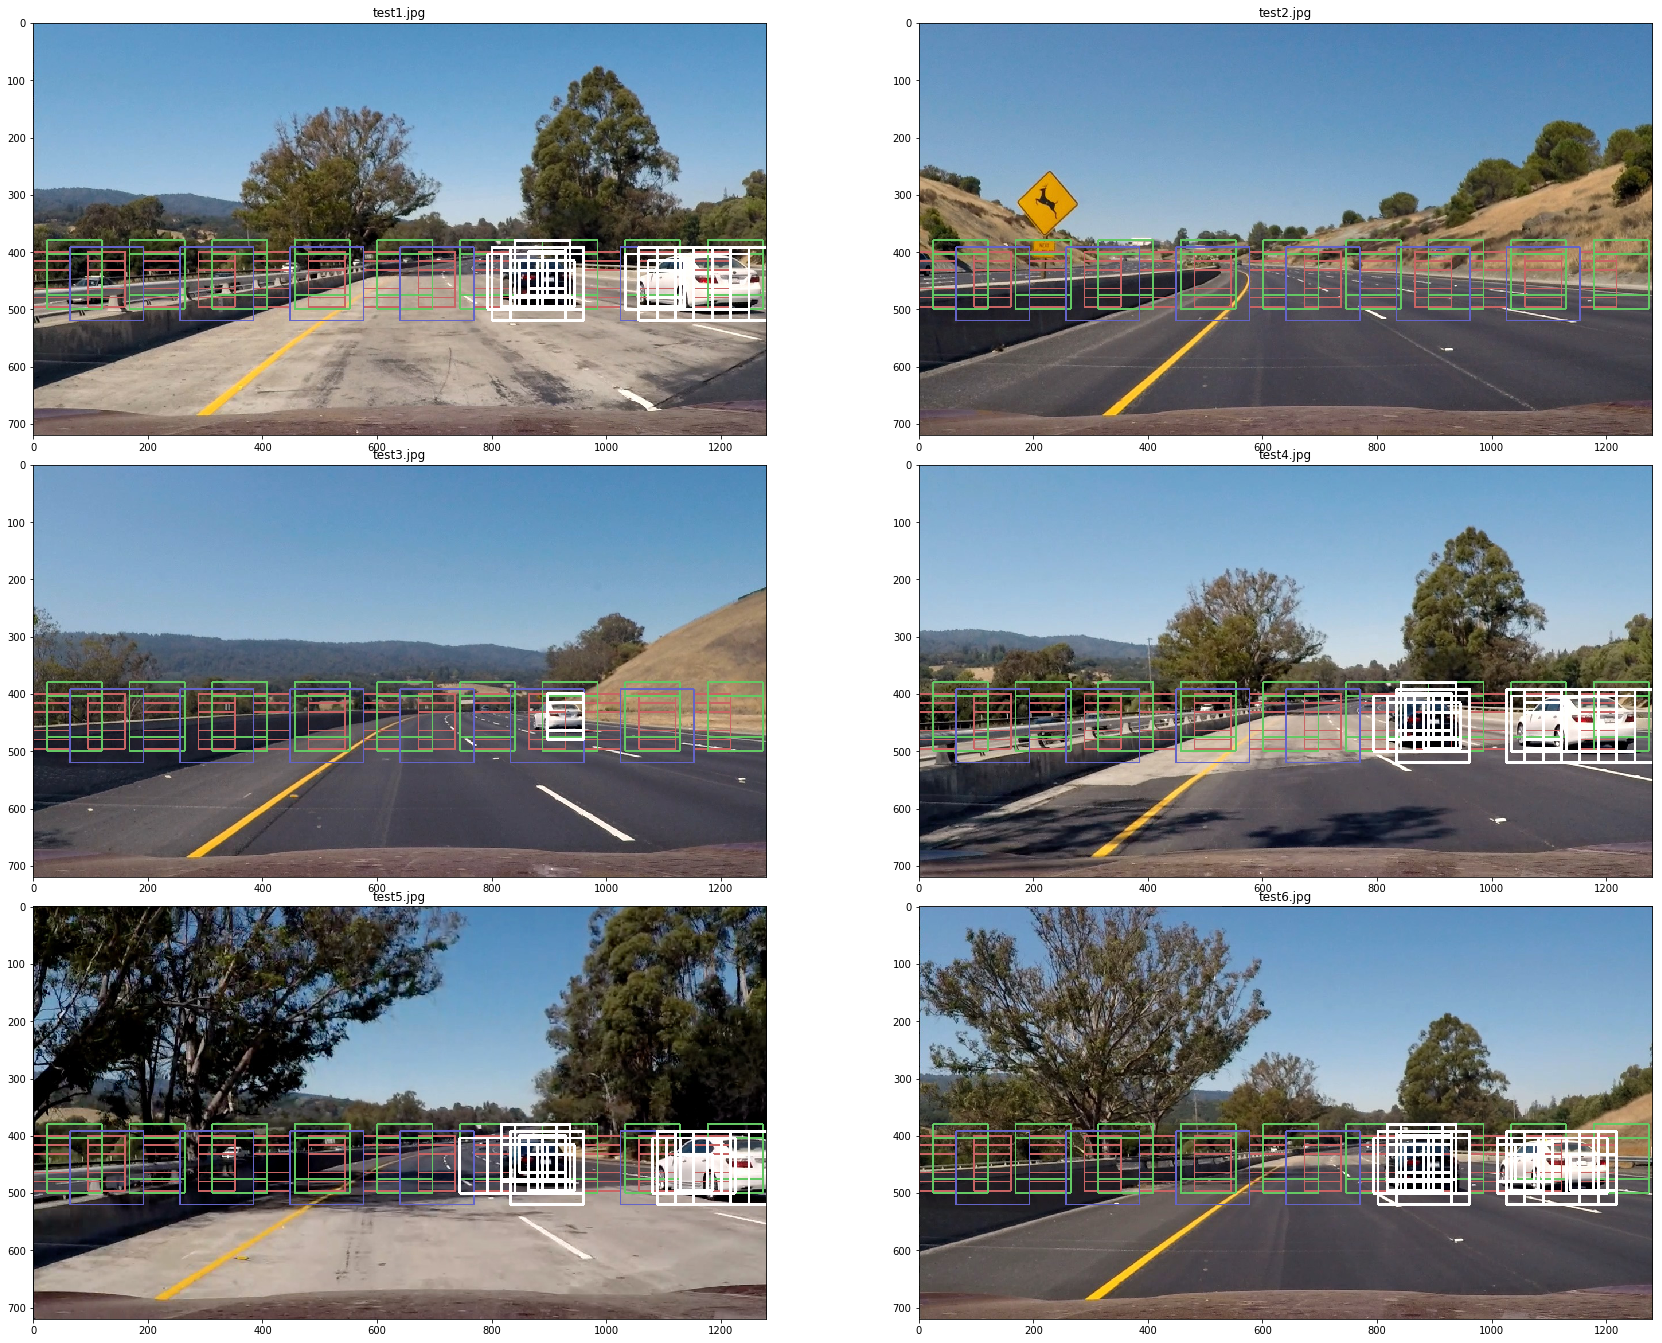

In [19]:
# Visualize the windows and detections
images = []
images += glob.glob('./../CarND-Vehicle-Detection/test_images/*.jpg')
h_list = [64, 96, 128]
ystart_list = [400, 380, 392]
ystop_list = [496, 500, 520]

f, axs = plt.subplots(int(len(images) / 2), 2, figsize=(24, 20))
f.tight_layout()

for idx, imgpath in enumerate(images):
    img = mpimg.imread(imgpath)
    bboxl, draw_image = find_cars_multi_log(img, ystart_list, ystop_list, h_list, cls_nhsto10, draw_image=True)
    i, j = divmod(idx,2)
    axs[i,j].imshow(draw_image)
    axs[i,j].set_title(imgpath[-9:])
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(out_img_folder + 'sliding_windows.jpg')  

In [20]:
# Define a class to receive the characteristics of each vehicle detection
# Objects defined as "Vehicles" will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self):
        self.label = -1
        self.detected = False  # was the vehicle detected in the last iteration
        self.reliable = False  # if the vehicle detected in more than 10 frames
        self.hiding = False  # if the vehicle is at behind of another vehicle
        self.n_detections = 0  # number of times this vehicle has been detected
        self.n_nondetections = 0  # number of consecutive times this car has not been detected
        self.xpixels = None  # Pixel x values of last detection
        self.ypixels = None  # Pixel y values of last detection
        self.recent_xfitted = []  # xposition of the last n fits of the bounding box
        self.bestx = None  # average x position of the last n fits
        self.recent_yfitted = []  # y position of the last n fits of the bounding box
        self.besty = None  # average y position of the last n fits
        self.recent_x2fitted = []  # width of the last n fits of the bounding box
        self.bestx2 = None  # average width of the last n fits
        self.recent_y2fitted = []  # height of the last n fits of the bounding box
        self.besty2 = None  # average height of the last n fits        
        self.recent_wfitted = []  # width of the last n fits of the bounding box
        self.bestw = None  # average width of the last n fits
        self.recent_hfitted = []  # height of the last n fits of the bounding box
        self.besth = None  # average height of the last n fits

In [21]:
# Used to add new corners of the box of label blob that is assumed to belong to the vehicle
def vehicle_add_box(vehicle, x1, x2, y1, y2, last_n):
    vehicle.detected = True
    vehicle.n_nondetections = 0
    vehicle.n_detections += 1
    if vehicle.n_detections >= 10:
        vehicle.reliable = True
    vehicle.xpixels = (x1, x2)
    vehicle.ypixels = (y1, y2)
    vehicle.recent_xfitted.append(x1)
    vehicle.recent_x2fitted.append(x2)
    vehicle.recent_yfitted.append(y1)
    vehicle.recent_y2fitted.append(y2)
    last_m = min(last_n, np.int(vehicle.n_detections / 2))
    vehicle.recent_xfitted = vehicle.recent_xfitted[-last_m:]
    vehicle.recent_x2fitted = vehicle.recent_x2fitted[-last_m:]
    vehicle.recent_yfitted = vehicle.recent_yfitted[-last_m:]
    vehicle.recent_y2fitted = vehicle.recent_y2fitted[-last_m:]
    vehicle.bestx = np.int(np.mean(vehicle.recent_xfitted))
    vehicle.bestx2 = np.int(np.mean(vehicle.recent_x2fitted))
    vehicle.besty = np.int(np.mean(vehicle.recent_yfitted))
    vehicle.besty2 = np.int(np.mean(vehicle.recent_y2fitted)) 

In [22]:
# Used to keep the list of vehicles, current vehicle index, heatmaps of previous frames
class Tracker():
    def __init__(self):
        self.vehicle_list = []
        self.heatmaps = []
        self.caridx = 0
        self.idx = 0
        self.heat_threshold = 0.75
        self.heat_frames = 5        

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [24]:
# Default function to draw labels on an image
# Used for debugging
def draw_labeled_bboxes_def(img, labels, color, thickness):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
        bbox = ((xmin, ymin), (xmax, ymax))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thickness)
    # Return the image
    return img

In [25]:
# Modified function to draw labels to image and keep track of vehicles
# Matches blob of labels with vehicles
def draw_labeled_bboxes_reverse(img, labels, tracker, log=False):
    # Iterate through all detected cars
    last_n = 15
    remove_n = 10
    v_visible = 5
    area_dif = 1.5
    vehicle_list = tracker.vehicle_list
    vehicle_new = []
    n_labels = (labels[1] + 1)
    labels_xy = []
    labels_xy.append(None)
    label_exists = [False] * n_labels
    label_matched = [False] * n_labels
    for car_number in range(1, n_labels):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
        labels_xy.append((xmin, xmax, ymin, ymax))
        
    for vehicle in vehicle_list:
        vehicle_exists = False
        area_vehicle = (vehicle.bestx2 - vehicle.bestx) * (vehicle.besty2 - vehicle.besty)
        vehicle_labels = 0
        x1, x2, y1, y2 = None, None, None, None
        for car_number in range(1, n_labels):
            if label_matched[car_number]:
                continue
            xmin, xmax, ymin, ymax = labels_xy[car_number]
            if not (xmax < vehicle.bestx or xmin > vehicle.bestx2 or
                    ymax < vehicle.besty or ymin > vehicle.besty2):
                area_label = (xmax - xmin) * (ymax - ymin)
                x1 = xmin
                x2 = xmax
                y1 = ymin
                y2 = ymax
                
                vehicle_exists = True
                label_exists[car_number] = True
                vehicle_labels += 1
                if log:
                    print('car', vehicle.label, 'label', car_number, 'area_vehicle', area_vehicle, 'area_label', area_label, 'label/car', float(area_label)/ area_vehicle)
                if (vehicle.hiding or
                        (vehicle.reliable and 
                            area_dif * area_vehicle < area_label)):
                    if (x1 >= xmin and x2 <= xmax and
                        y1 >= ymin and y2 <= ymax):
                        vehicle.hiding = True
                    else:
                        x1 = vehicle.bestx
                        x2 = vehicle.bestx2
                        y1 = vehicle.besty
                        y2 = vehicle.besty2
                        vehicle.hiding = False
                else:
                    break
        if vehicle_exists:
            vehicle_add_box(vehicle, x1, x2, y1, y2, last_n)
            vehicle_new.append(vehicle)
        else:
            vehicle.detected = False
            vehicle.n_nondetections += 1
            nondetections_to_remove = remove_n
            if vehicle.reliable:
                nondetections_to_remove += remove_n
            if vehicle.n_nondetections < nondetections_to_remove:
                vehicle_new.append(vehicle)
    for car_number in range(1, n_labels):
        if not label_exists[car_number]:
            vehicle = Vehicle()
            vehicle.label = tracker.caridx
            tracker.caridx += 1
            xmin, xmax, ymin, ymax = labels_xy[car_number]
            vehicle_add_box(vehicle, xmin, xmax, ymin, ymax, last_n)
            vehicle_new.append(vehicle)
    v = 0
    for vehicle in vehicle_new:
        nondetections_to_hide = v_visible
        if vehicle.reliable:
            nondetections_to_hide += last_n
        if vehicle.n_nondetections < nondetections_to_hide:
            bbox0 = (vehicle.bestx, vehicle.besty)
            bbox1 = (vehicle.bestx2, vehicle.besty2)
            cv2.rectangle(img, bbox0, bbox1, (0,0,255), 6)
            cv2.putText(img, str(vehicle.label),(bbox0[0]+5,bbox0[1]+28),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)
        v += 1
    tracker.vehicle_list = vehicle_new    
    tracker.idx += 1         
    # Return the image
    return img

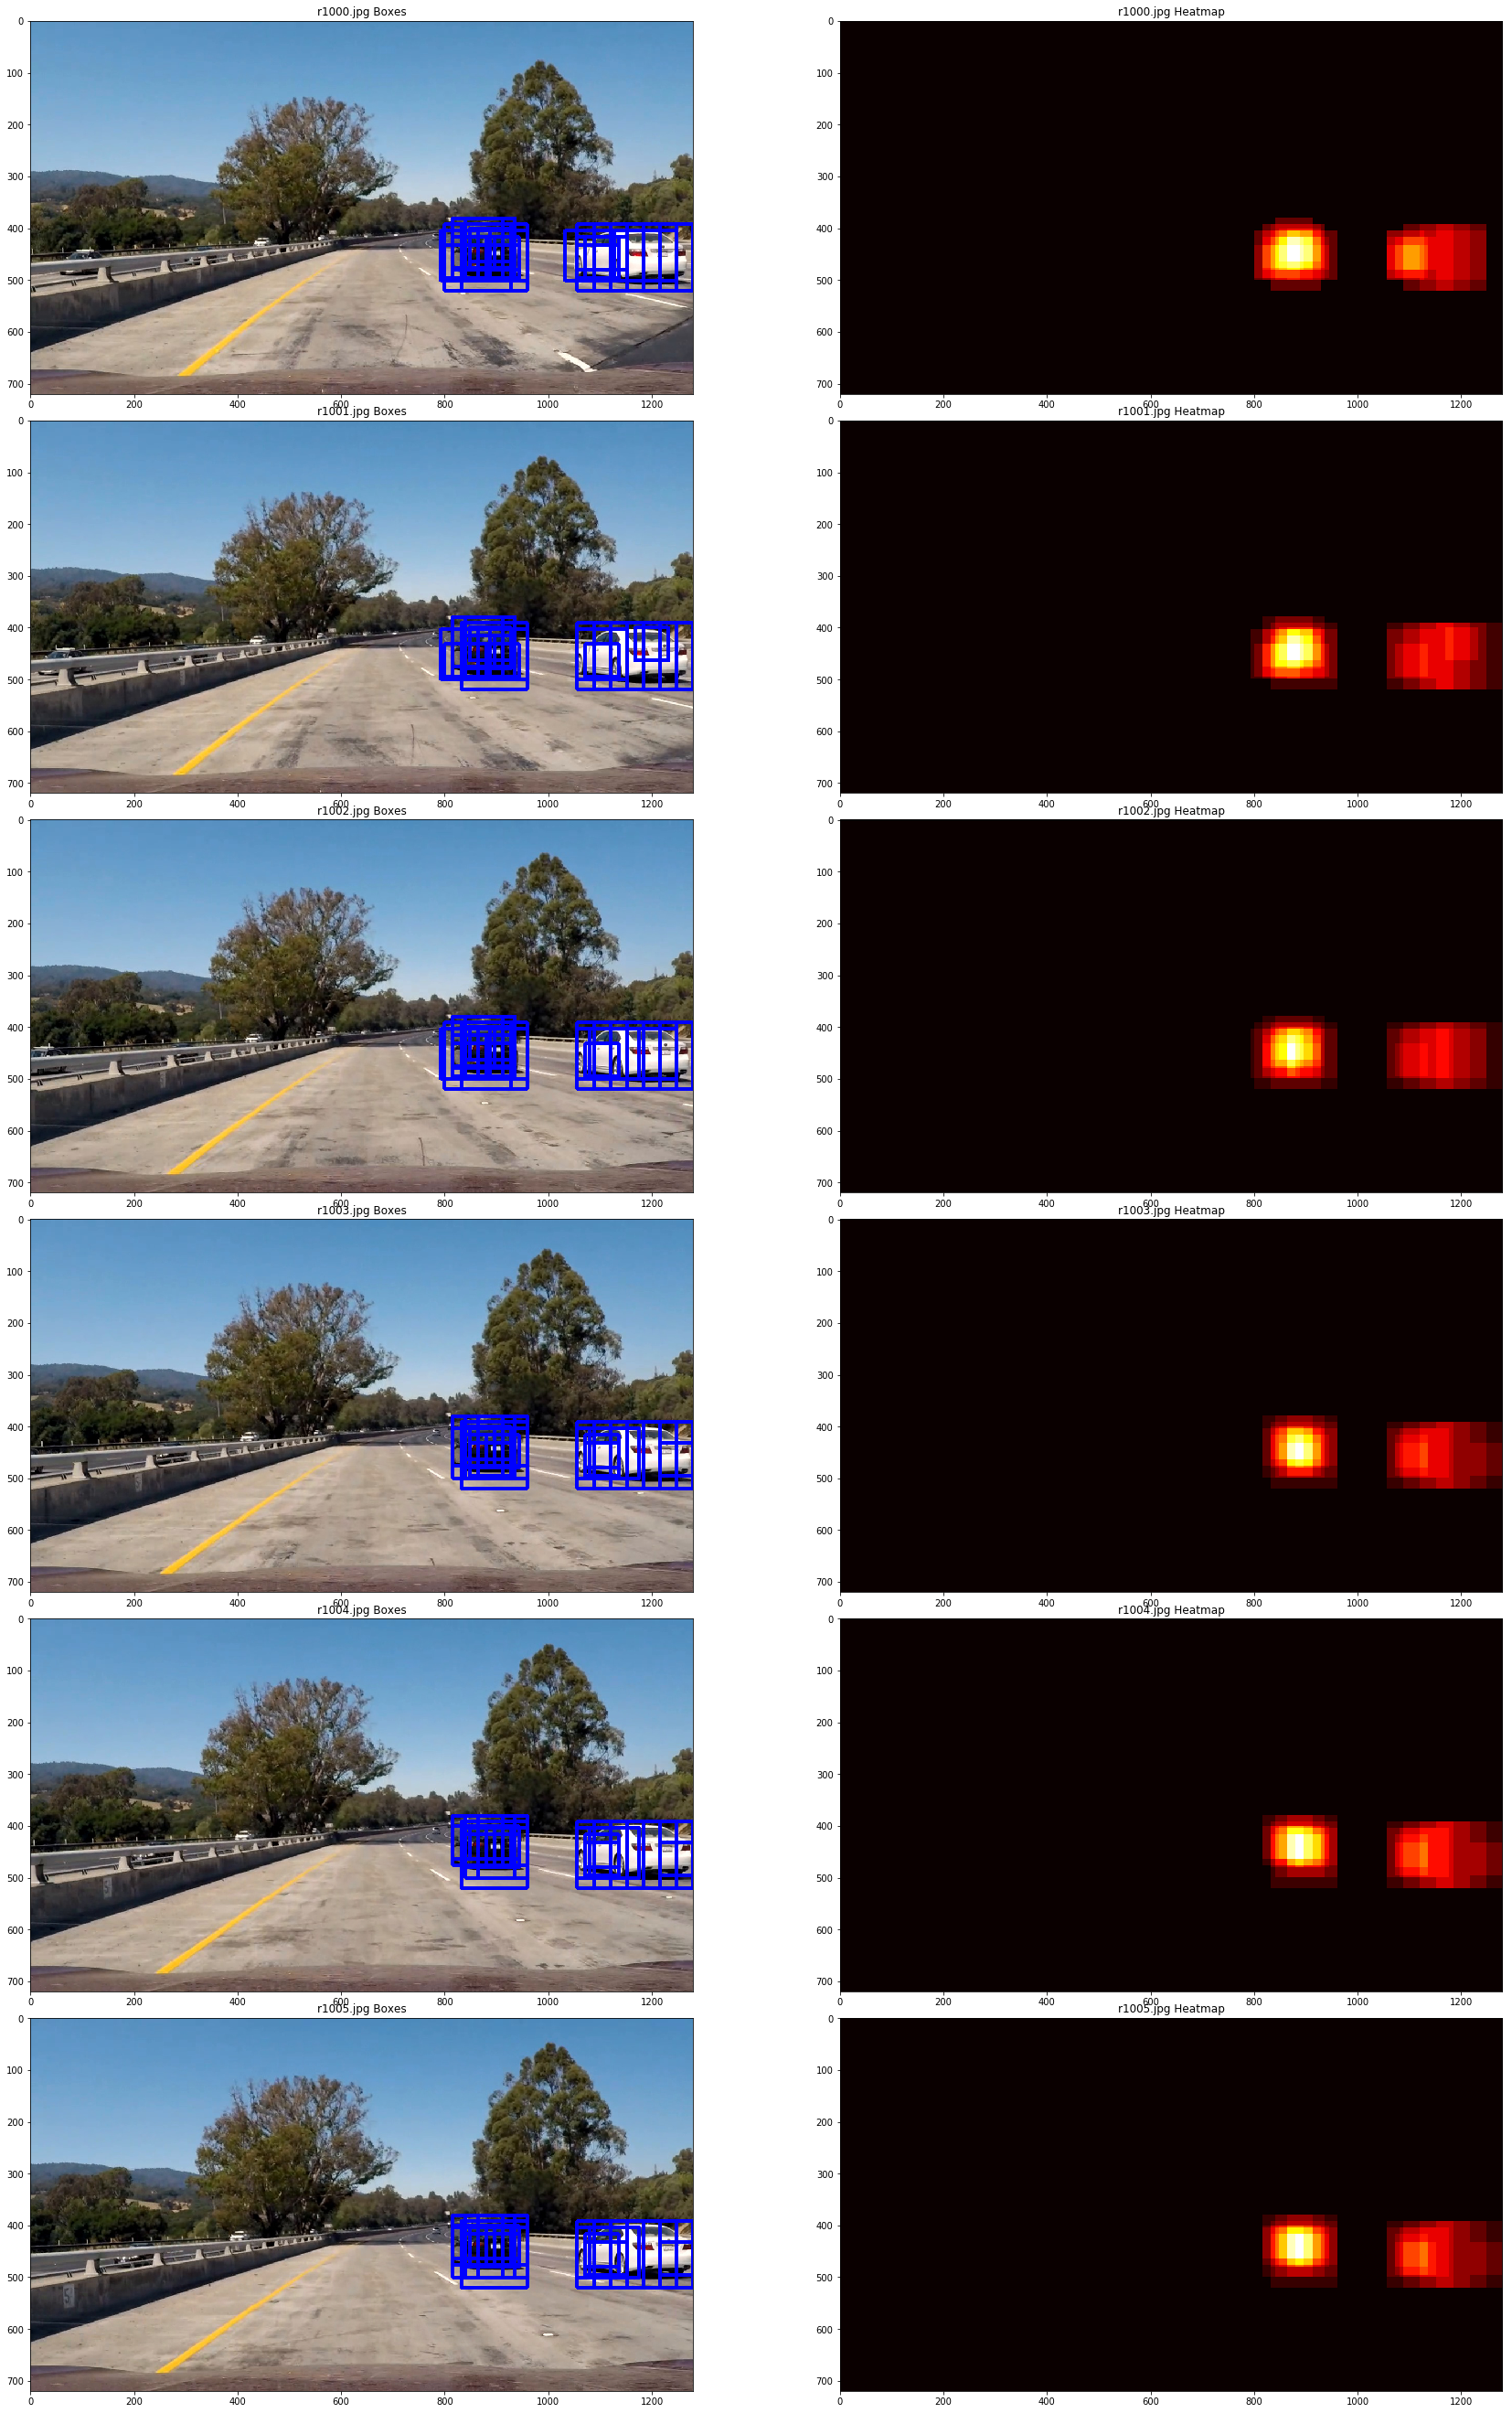

In [26]:
# Visualize the pipeline for six images

images = []
for i in range(1000, 1006):
    images.append('./../../180_AdvancedLaneFinding/CarND-Advanced-Lane-Lines/prj_images/pr%d.jpg' % i)

h_list = [64, 96, 128]
ystart_list = [400, 380, 392]
ystop_list = [496, 500, 520]
    
f, axs = plt.subplots(len(images), 2, figsize=(24, 40))
f.tight_layout()
tr = Tracker()
final_heat = None
final_img = None
for idx, imgpath in enumerate(images):
    img = mpimg.imread(imgpath)
    bboxl = find_cars_multi(img, ystart_list, ystop_list, h_list, cls_nhsto10)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_img = add_heat(heat, bboxl)
    tr.heatmaps.append(heat_img)
    n_heat = len(tr.heatmaps)
    if n_heat == 1:
        heat = apply_threshold(heat,1)
    else:
        if n_heat >= tr.heat_frames:
            tr.heatmaps = tr.heatmaps[-tr.heat_frames:]
        heat = np.asarray(tr.heatmaps).sum(axis=0)
        heat = apply_threshold(heat, tr.heat_threshold * n_heat)
    final_heat = heat
    final_img = img
    heat_img = np.clip(heat_img, 0, 255)
    axs[idx,0].imshow(draw_boxes(img, bboxl))
    axs[idx,0].set_title(imgpath[-9:] + ' Boxes')
    axs[idx,1].imshow(heat_img, cmap='hot')
    axs[idx,1].set_title(imgpath[-9:] + ' Heatmap')    
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(out_img_folder + 'bboxes_and_heat.png')  

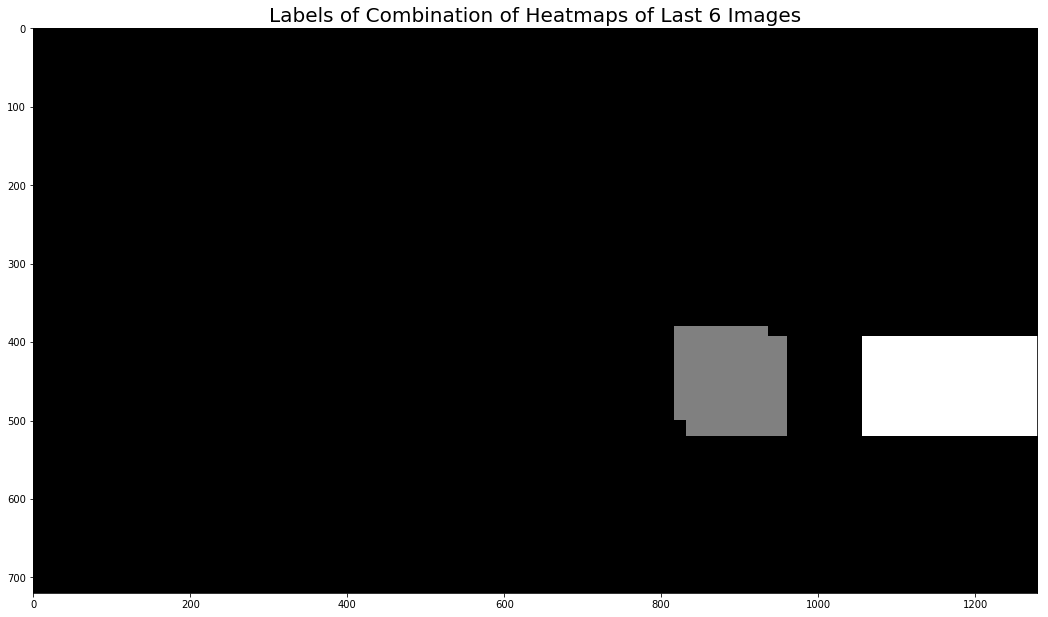

In [27]:
labels = label(final_heat)
plt.figure(figsize=(18,12))
plt.imshow(labels[0], cmap='gray')
plt.title('Labels of Combination of Heatmaps of Last 6 Images', fontsize=20)
plt.savefig(out_img_folder + 'labels_map.png')

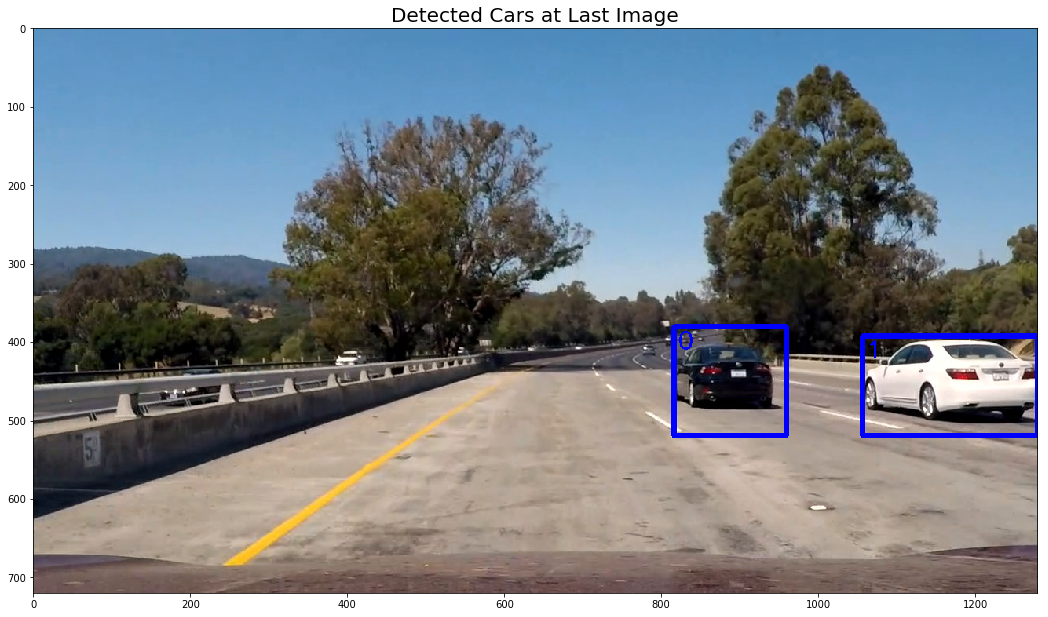

In [28]:
draw_image = draw_labeled_bboxes_reverse(np.copy(final_img), labels, tr)
plt.figure(figsize=(18,12))
plt.imshow(draw_image)
plt.title('Detected Cars at Last Image', fontsize=20)
plt.savefig(out_img_folder + 'output_bboxes.png')

In [29]:
def process_image(img):
    h_list = [64, 96, 128]
    ystart_list = [400, 380, 392]
    ystop_list = [496, 500, 520]
    cls_svm = cls_nhsto10

    bboxl = find_cars_multi(img, ystart_list, ystop_list, h_list, cls_svm)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxl)

    tr.heatmaps.append(heat)
    n_heat = len(tr.heatmaps)

    if n_heat == 1:
        heat = apply_threshold(heat,1)
    else:
        if n_heat >= tr.heat_frames:
            tr.heatmaps = tr.heatmaps[-tr.heat_frames:]
        heat = np.asarray(tr.heatmaps).sum(axis=0)
        heat = apply_threshold(heat, tr.heat_threshold * n_heat)    

    labels = label(heat)
    draw_img = draw_labeled_bboxes_reverse(np.copy(img), labels, tr)
    
    return draw_img

In [30]:
def process_image_best(img):
    h_list = [64, 96, 128, 192]
    ystart_list = [408, 392, 392, 392]
    ystop_list = [488, 512, 520, 584]    
    heat_threshold = 0.95
    heat_frames = 5
    cls_svm = cls_best

    bboxl = find_cars_multi(img, ystart_list, ystop_list, h_list, cls_svm)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxl)

    tr.heatmaps.append(heat)
    n_heat = len(tr.heatmaps)

    if n_heat == 1:
        heat = apply_threshold(heat,1)
    else:
        if n_heat >= heat_frames:
            tr.heatmaps = tr.heatmaps[-heat_frames:]
        heat = np.asarray(tr.heatmaps).sum(axis=0)
        heat = apply_threshold(heat, heat_threshold * n_heat)    

    labels = label(heat)
    draw_img = draw_labeled_bboxes_reverse(np.copy(img), labels, tr)
    
    return draw_img

In [33]:
from keras.models import Sequential, model_from_json
import json

In [36]:
with open('./cnn/model.json', 'r') as mfile:
    model = model_from_json(json.load(mfile))
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
model.load_weights('./cnn/model.h5')

In [37]:
def process_image_cnn(img):
    h_list = [64, 96, 128]
    ystart_list = [408, 392, 392]
    ystop_list = [488, 512, 520]
    heat_threshold = 3.5
    heat_frames = 6    

    bboxl = find_cars_cnn(img, ystart_list, ystop_list, h_list, model)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxl)

    tr.heatmaps.append(heat)
    n_heat = len(tr.heatmaps)

    if n_heat == 1:
        heat = apply_threshold(heat,7)
    else:
        if n_heat >= heat_frames:
            tr.heatmaps = tr.heatmaps[-heat_frames:]
        heat = np.asarray(tr.heatmaps).sum(axis=0)
        heat = apply_threshold(heat, heat_threshold * n_heat)    

    labels = label(heat)
    draw_img = draw_labeled_bboxes_reverse(np.copy(img), labels, tr)
    
    return draw_img

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
tr = Tracker()
output_test_video = './output_images/test_video.mp4'
input_test_video = './../CarND-Vehicle-Detection/test_video.mp4'

clip1 = VideoFileClip(input_test_video)
video_clip = clip1.fl_image(process_image)  # COLOR IMAGES
video_clip.write_videofile(output_test_video, audio=False)

[MoviePy] >>>> Building video ./output_images/test_video.mp4
[MoviePy] Writing video ./output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video.mp4 



In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_test_video))

In [41]:
tr = Tracker()
output_project_video = './output_images/project_video.mp4'
input_project_video = './../CarND-Vehicle-Detection/project_video.mp4'

clip1 = VideoFileClip(input_project_video)
video_clip = clip1.fl_image(process_image)  # COLOR IMAGES
video_clip.write_videofile(output_project_video, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [07:15<00:00,  2.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 



In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))

In [43]:
tr = Tracker()
output_cnn_video = './output_images/project_video_cnn.mp4'
input_project_video = './../CarND-Vehicle-Detection/project_video.mp4'

clip1 = VideoFileClip(input_project_video)
video_clip = clip1.fl_image(process_image_cnn)  # COLOR IMAGES
video_clip.write_videofile(output_cnn_video, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_cnn.mp4
[MoviePy] Writing video ./output_images/project_video_cnn.mp4


100%|█████████▉| 1260/1261 [01:50<00:00, 11.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_cnn.mp4 



In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_cnn_video))

In [45]:
tr = Tracker()
output_project_video2 = './output_images/project_video2.mp4'
input_project_video = './../CarND-Vehicle-Detection/project_video.mp4'

clip1 = VideoFileClip(input_project_video)
video_clip = clip1.fl_image(process_image_best)  # COLOR IMAGES
video_clip.write_videofile(output_project_video2, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video2.mp4
[MoviePy] Writing video ./output_images/project_video2.mp4


100%|█████████▉| 1260/1261 [13:13<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video2.mp4 



In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video2))